<a href="https://colab.research.google.com/github/wangwangwang77/pydata-book/blob/1st-edition/Neo_Classical_Discrete_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**From a series of application of modern interpolation methods for economics: written by [Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)**


Note: This notebook should take at most **50 seconds** to run. From `Runtime` choose `Run all` to run this code.

Consider the following problem:

$\begin{align}
\quad & \max_{\{c_t\}_{t=0}^\infty } \sum \beta^t u(c_t)\\
\quad & \text{s.t.}\quad  k_{t+1} = f(k_t) + (1-\delta) k_t -c_t\\
\quad & k_{t+1} \geq 0\\
\quad & k_0 \quad \text{is given}.
\end{align}$

The Euler equation can be written as:

$\begin{align}
\quad & u'(c_t) = \beta u'(c_{t+1})\big[f'(k_{t+1})+(1-\delta)\big]
\end{align}$

To pin down the solution transversality condition is required:

$\begin{align}
\quad & \lim_{T\rightarrow \infty} u'(c_t)k_{t+1} = 0
\end{align}$

The solution of this problem can be written as the **root** of a **functional operator**.

$\begin{align}
\quad & \beta u'\big(c(t+1)\big)\bigg[f'\big(k(t+1)\big)+(1-\delta)\bigg] - u'\big(c(t)\big) = 0 \\
\quad & f\big(k(t)\big) + (1-\delta) k(t) -c(t) - k(t+1)  = 0\\
\quad & k(0)-k_0 = 0.
\end{align}$

In this example I focus on the case of:
 1. $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$, and $f(k) = k^\alpha$,

 2.  $\sigma = 1$, $\beta = 0.9$, $\alpha = \frac{1}{3}$.

## Importing packages (ignore it)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
fontsize= 14
ticksize = 14
figsize = (12, 4.5)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)

## Setting up the model parameters


In [ ]:
class Params:
    def __init__(self,
                 alpha = 1.0/3.0,
                 beta = 0.9,
                 delta = 0.1,
                 k_0 = 1.0,
                ):
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.k_0 = k_0


## Some useful functions:
$f(k)$: Production function

$f'(k)$: derivative of the production function

$SS$: Steady states of the capital and consumption

In [ ]:
def f(k):
    alpha = Params().alpha
    return k**alpha

In [ ]:
def f_prime(k):
    alpha = Params().alpha
    return  alpha*(k**(alpha -1))

In [ ]:
def u_prime(c):
    out = c.pow(-1)
    return out

In [ ]:
class SS: #steady state
    def __init__(self):
        self.delta = Params().delta
        self.beta = Params().beta
        self.alpha = Params().alpha
        base = ((1.0/self.beta)-1.0+self.delta)/self.alpha
        exponent = 1.0/(self.alpha-1)
        self.k_ss = base**exponent
        self.c_ss = f(self.k_ss)-self.delta*self.k_ss

## Preparing the grid and the data loader (for stochastic gradient method)

In [ ]:
class Grid_data:
    def __init__(self,
                 max_T = 32,
                 batch_size = 8):
        self.max_T = max_T
        self.batch_size = batch_size
        self.time_range = torch.arange(0.0, self.max_T , 1.0)
        self.grid = self.time_range.unsqueeze(dim = 1)

In [ ]:
class Data_label(Dataset):

    def __init__(self,data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self,index):
            return self.time[index]

    def __len__(self):
        return self.n_samples

In [ ]:
train_data = Grid_data().grid
train_labeled = Data_label(train_data)
train = DataLoader(dataset = train_labeled, batch_size = 8 , shuffle = True )

## Defining the approximating function (neural networks):
Here the the approximation function (deep neural net) is $\hat{q}=[\hat{c},\hat{k}] : \mathbb{R} → \mathbb{R}^2$.


In [ ]:
class NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Tanh())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,2))
        module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)


    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        return  out

## Optimization (Learning) process

#### An auxiliary function that extracts the learning rate


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### Initializing the neural net and defining the optimizer



In [ ]:
q_hat= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(q_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

In [ ]:
delta = Params().delta
beta = Params().beta
k_0 = Params().k_0

In [ ]:
num_epochs = 1001

In [ ]:
for epoch in range(num_epochs):
    for i, time in enumerate(train):
        time_zero = torch.zeros([1,1])
        time_next = time+1
        c_t = q_hat(time)[:,[0]]
        k_t = q_hat(time)[:,[1]]
        c_tp1 = q_hat(time_next)[:,[0]]
        k_tp1 = q_hat(time_next)[:,[1]]
        k_t0 = q_hat(time_zero)[0,1]

        res_1 = c_t-f(k_t)-(1-delta)*k_t + k_tp1 #Budget constraint
        res_2 = (u_prime(c_t)/u_prime(c_tp1)) - beta*(f_prime(k_tp1)+1-delta) #Euler
        res_3 = k_t0-k_0 #Initial Condition

        loss_1 = res_1.pow(2).mean()
        loss_2 = res_2.pow(2).mean()
        loss_3 = res_3.pow(2).mean()
        loss = 0.1*loss_1+0.8*loss_2+0.1*loss_3

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    scheduler.step()

    if epoch == 0:
         print('epoch' , ',' , 'loss' , ',', 'loss_bc' , ',' , 'loss_euler' , ',' , 'loss_initial' ,
               ',', 'lr_rate')
    if epoch % 100 == 0:
          print(epoch,',',"{:.2e}".format(loss.detach().numpy()),',',
                "{:.2e}".format(loss_1.detach().numpy()) , ',' , "{:.2e}".format(loss_2.detach().numpy())
               , ',' , "{:.2e}".format(loss_3.detach().numpy()), ',', "{:.2e}".format(get_lr(optimizer)) )


epoch , loss , loss_bc , loss_euler , loss_initial , lr_rate
0 , 3.15e-03 , 1.48e-03 , 2.99e-03 , 6.06e-03 , 1.00e-03
100 , 1.04e-07 , 6.87e-07 , 4.23e-08 , 1.17e-08 , 8.00e-04
200 , 5.18e-08 , 1.42e-07 , 4.02e-08 , 5.43e-08 , 6.40e-04
300 , 2.53e-08 , 2.87e-08 , 2.71e-08 , 7.59e-09 , 5.12e-04
400 , 1.31e-08 , 4.07e-08 , 1.07e-08 , 4.93e-09 , 4.10e-04
500 , 6.36e-08 , 5.34e-07 , 7.97e-09 , 3.90e-08 , 3.28e-04
600 , 1.35e-08 , 4.48e-08 , 1.12e-08 , 5.46e-10 , 2.62e-04
700 , 3.20e-09 , 3.96e-09 , 3.50e-09 , 2.51e-11 , 2.10e-04
800 , 3.05e-09 , 1.62e-08 , 1.66e-09 , 1.05e-09 , 1.68e-04
900 , 1.05e-08 , 6.94e-08 , 4.20e-09 , 1.62e-09 , 1.34e-04
1000 , 1.06e-08 , 5.73e-08 , 2.52e-09 , 2.84e-08 , 1.07e-04


## Plotting the results


In [ ]:
time_test = Grid_data().grid
c_hat_path = q_hat(time_test)[:,[0]].detach()
k_hat_path = q_hat(time_test)[:,[1]].detach()

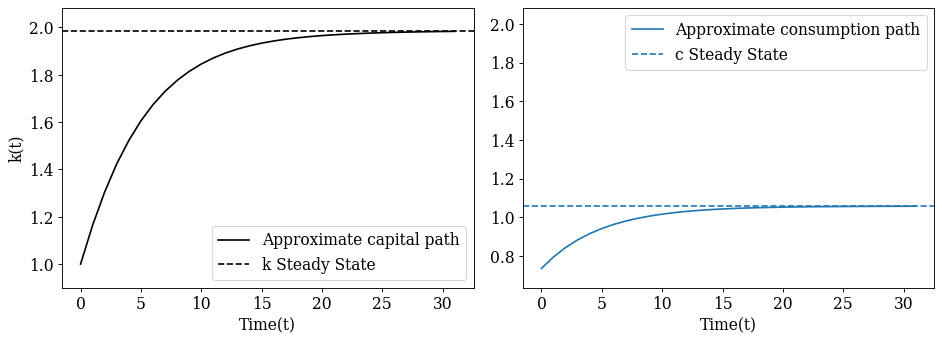

In [ ]:
plt.subplot(1, 2, 1)


plt.plot(time_test,k_hat_path, color='k',  label = r"Approximate capital path")
plt.axhline(y=SS().k_ss, linestyle='--',color='k', label="k Steady State")
plt.ylabel(r"k(t)")
plt.xlabel(r"Time(t)")
plt.ylim([Params().k_0-0.1,SS().k_ss+0.1 ])
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(time_test,c_hat_path,label= r"Approximate consumption path")
plt.axhline(y=SS().c_ss, linestyle='--',label="c Steady State")
plt.xlabel(r"Time(t)")
plt.ylim([c_hat_path[0]-0.1,SS().k_ss+0.1 ])
plt.tight_layout()
plt.legend(loc='best')
plt.tight_layout()
plt.show()
